In [1]:
import os
import struct
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.optimizers import Adam
# %matplotlib inline

2021-10-06 10:27:15.056133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
root = os.getcwd()
DIR_TO_TRAIN_DATA = os.path.join(root, "dataset", "Train.cdb")
DIR_TO_TEST_DATA = os.path.join(root, "dataset", "Test.cdb")

##### The next 5 cells have been taken from:
https://github.com/masoud-zokaee/keras-farsi-digits
##### These are for reading the HODA dataset 

In [5]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result

In [6]:
def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

In [7]:
def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels

In [8]:
def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [9]:
X_train, y_train = read_hoda_dataset(dataset_path=DIR_TO_TRAIN_DATA,
                                images_height=28,
                                images_width=28,
                                one_hot=True,
                                reshape=False)

X_test, y_test = read_hoda_dataset(dataset_path=DIR_TO_TEST_DATA,
                              images_height=28,
                              images_width=28,
                              one_hot=True,
                              reshape=False)

/tmp/ipykernel_11907/2589433811.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros(shape=[len(labels)], dtype=np.int)


5


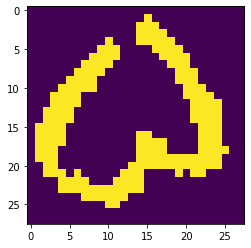

In [11]:
import random
sample_number = random.randint(0, len(X_train)) 
plt.imshow(X_train[sample_number,:,:])
print(np.argmax(y_train[sample_number]))

In [12]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))

2021-10-06 10:30:01.662641: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-06 10:30:01.663821: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-06 10:30:01.711870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 10:30:01.712246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.665GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2021-10-06 10:30:01.712276: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-06 10:30:01.798295: I tensorflow/stream_executor/platform/de

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [14]:
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.0001)
metrics = ["accuracy"]

In [15]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

In [16]:
epochs = 10
batch_size = 128
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

2021-10-06 10:30:20.234164: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-10-06 10:30:20.343038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-06 10:30:20.368367: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393175000 Hz


Epoch 1/10


2021-10-06 10:30:20.786509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-06 10:30:21.322514: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-10-06 10:30:23.274548: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-10-06 10:30:23.326553: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


469/469 [==============================] - 16s 17ms/step - loss: 1.1942 - accuracy: 0.6942
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1610 - accuracy: 0.9521
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1040 - accuracy: 0.9703
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0774 - accuracy: 0.9782
Epoch 5/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0611 - accuracy: 0.9821
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0527 - accuracy: 0.9844
Epoch 7/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0420 - accuracy: 0.9872
Epoch 8/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0385 - accuracy: 0.9884
Epoch 9/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0342 - accuracy: 0.9888
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0321 - accuracy: 0.9898


In [17]:
model.save("./model.h5")

The image shows the number 9


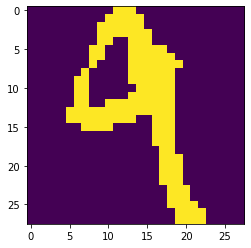

In [23]:
random_sample = random.randint(0, len(X_test))
to_be_predicted = np.expand_dims(X_test[random_sample,:,:], 0)
plt.imshow(X_test[random_sample,:,:])
prediction = np.argmax(model.predict(to_be_predicted))
print(f"The image shows the number {prediction}")